# Preliminaries

In [1]:
!pip install gpytorch
  
import math
import torch
import gpytorch 
import sklearn
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


%matplotlib inline
%load_ext autoreload
%autoreload 2



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/MSC Thesis

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/MSC Thesis


In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

predictors = pd.read_csv('pred_inputs.csv')
predict_these = np.unique(predictors['INSTRUMENT'])

def from_csv(instrument):
    df = pd.read_csv('Data/' + instrument + '.csv')
    df['date'] = pd.to_datetime(df['date']).dt.date
    df.set_index('date',inplace=True)
    df = df.sort_values(by = 'date')
    df.columns = [instrument]
    
    return df
  
def preprocessing(commodity):
    #####################################################################################
    # This ensures chronological order (some time series are NOT in order)              #
    #####################################################################################
    
    prices_df = db.get_instrument_data(commodity)
    prices_df = prices_df.sort_values(by = 'date')
    prices_df.columns = [commodity]
    return prices_df
  
def get_predictors(commodity, predictors):
    ####################################################################
    # This returns the df containing the values of the commodity to be #
    # predicted as well as that of its predictors.                     #
    #                                                                  #
    # Args:                                                            #
    # 1) commodity: name of the commodity                              #
    # 2) predictors: the dataframe sent by Michael Button              #
    ####################################################################
    
    # get a list of all its predictors
    Pred = list(predictors.loc[predictors['INSTRUMENT'] == commodity]['INPUT'])
    Pred = [p for p in Pred if p != commodity]
    
    # Initialize the dataframe with the commodity we want to predict
    DF = from_csv( commodity )
    
    # Keep adding the predictors
    for predictor in Pred:
        temp_df = from_csv( predictor )
        DF = DF.join(temp_df)
        
    DF.index = pd.to_datetime(DF.index)
    return DF
  
def price_to_returns(prices_df, diff):
    ###############################################################
    # This changes the price data to 5 day log difference.        #
    # If X has negative values, use the following scheme:         # 
    #          X := X - min(X) + 1                                #
    ###############################################################
    
    # forward fill
    prices_df.fillna(method='ffill', inplace = True)
    
    returns_df = prices_df.copy()
    for colname in prices_df.columns:
        temp = prices_df.loc[:,colname]
        
        if np.min(temp) <= 0:
            temp = temp - np.min(temp) + 1
        returns_df[colname] = np.log(temp) - np.log(temp.shift(diff))

    # drop rows with NaN
    returns_df.dropna(inplace = True)
    return returns_df


  
def feature_generation(metal, time_pred = [1,5,22]):
  metal = metal + '_lme_prices'
  Metal_DF = get_predictors(metal, predictors)
  # remove comex, since comex is not 
  Metal_DF = Metal_DF[[col for col in list(Metal_DF.columns) if 'comex' not in col]]
  
  # 1, 5, 22 days
  # log difference L
  LD = [price_to_returns(Metal_DF, t_pred) for t_pred in time_pred]

  # EWMA of L
  # EWMA = [L.ewm(span = horizon).mean() for horizon, L in zip(time_pred, LD)]
  EWMA = [LD[0].ewm(halflife = horizon).mean() for horizon in time_pred ]

  # EWMV of L
  # 1. calculate expanding window mean for the returns (1 day) 
  # 2. subtract rolling mean and take square
  EM = LD[0].expanding(2).mean() 
  EWMV = [((LD[0] - EM)**2).ewm(span = horizon).mean()**0.5 for horizon in time_pred ]
  
  # rename columns
  for horizon, ld, ewma, ewmv in zip(time_pred, LD, EWMA, EWMV):
    ld.columns = [col + '_LD_' + str(horizon) for col in ld.columns]
    ewma.columns = [col + '_EWMA_' + str(horizon) for col in ewma.columns]
    ewmv.columns = [col + '_EWMV_' + str(horizon) for col in ewmv.columns]
    
  # merge together 
  ALL_FEATURES = pd.concat([pd.concat(DFS, axis = 1, sort=True) for DFS in [LD, EWMA, EWMV]], axis = 1)
  ALL_FEATURES_columns = list(ALL_FEATURES.columns)
  ALL_FEATURES_columns.sort()
  ALL_FEATURES = ALL_FEATURES.loc[:,ALL_FEATURES_columns]
  ALL_FEATURES.dropna(inplace = True)
  
  return ALL_FEATURES



def feature_extraction(DF, column_name, lag):
  # This extracts the relevant predictors for the column_name
  # threshold is the % of predictors that we want to include
  # Mutual Information
  DF_metal = DF.loc[:,[column_name]]
  MI_table = np.zeros(DF.shape[1])
  for i in range(DF.shape[1]):
      MI = sklearn.feature_selection.mutual_info_regression(DF_metal, DF.iloc[:,i])
      MI_table[i] = MI
  
  tol = 1e-3
  MI_table_2 = MI_table[MI_table > tol]
  out, bins = pd.qcut(MI_table_2, [0.9, 1], retbins=True)
  selected_cols = list(MI_table > bins[-2])
  
  DF = DF.loc[:,selected_cols].shift(periods = lag)
  DF.columns = [col + '_lag' for col in DF.columns]
  DF = pd.concat([DF_metal, DF], axis = 1, sort = True).dropna()
  time_column = pd.DataFrame(index = DF.index, 
                             data = np.arange(DF.shape[0])*0.01 , 
                             columns = ['time'] )
  DF = pd.concat([DF, time_column], axis = 1)
  # add time column
  
  
  return(DF)



# 1. Warped GP

In [0]:
A = torch.linspace(1,10,10).view(2,5)
B = torch.linspace(1,15,15).view(3,5)


torch.norm( (A[:,None,] - A[None,:])/torch.linspace(1,5,5) , dim = 2)
torch.norm(torch.tensor([1.,1.]))

tensor(1.4142)

## 1.1 Some helper functions

In [0]:
def softplus(param):
    return torch.log(1 + torch.exp(param) )

  
def RBF(lengthscale, X1, X2):
    if len(X1.shape) == 1:
      X1 = torch.unsqueeze(X1, 0)
      X2 = torch.unsqueeze(X2, 1)
      return torch.exp( -((X1 - X2)/softplus(lengthscale) )**2 )
    else:
      return torch.exp(-torch.norm((X1[:,None] - X2[None,:])/lengthscale, dim = 2)**2)
    
      
  
def Warp(A, B, C, Observations):
    f = Variable(torch.zeros(len(Observations)))
    for a,b,c in zip(A,B,C):
        f += a * torch.tanh(b * (Observations + c))
    return (f + Observations)

def Warp_derivative(A,B,C, Observations):
    df = Variable(torch.zeros(len(Observations)))
    for a,b,c in zip(A,B,C):
        df += a * (1 - torch.tanh(b * (Observations + c))**2 ) * b
    return df+1

def Warp_inverse(A,B,C, Latents):
    # This function uses the Newton Raphson Method (iterative) which finds the roots of a function f. 
    # where x1 = x0 - f(x0)/f'(x0)
    # Here, our f is defined as f = Latents - warp(observations)
    
    Observation = torch.randn(size = Latents.shape)
    for i in range(10):
        Observation += (Latents - Warp(A,B,C, Observation) )/(Warp_derivative(A,B,C, Observation) )
    return(Observation)

def Warp_inverse_NS(A,B,C, Latents):
    #this is a Numerically Stable way of finding the inverse
        
    if torch.tensor(Latents).shape == torch.Size([]):
        Latents = torch.tensor(Latents).unsqueeze(0)
      
    Inverse = torch.zeros(Latents.shape)

    for i,latent in enumerate(Latents):
        
        #first find the domain of observations corresponding to the latents
        init_obs_guess_upper = torch.tensor([10])
        init_obs_guess_lower = torch.tensor([-10])
        #determine if the domain is positive or negative
        if Warp(A,B,C, torch.zeros(1) ) >= latent:
            sign = -1.0
        else: 
            sign = 1.0
        tol = 1e-6
        
        
        niter = 0
        if sign == 1:
            top = torch.tensor([sign])
            bottom = torch.zeros(1)
            # first determine the range [bottom,top] such that latent is in f([bottom,top])
            while Warp(A,B,C,top) < latent:
                bottom = top
                top = 2 * top
            
            while torch.abs(Warp(A,B,C, top) - latent) >= tol and niter < 100:
                niter += 1
                upper_domain = Warp(A,B,C, 0.5*(bottom + top) ) 
                if upper_domain < latent:
                    bottom = 0.5* (bottom + top) 
                elif upper_domain > latent:
                    top = 0.5*(bottom + top) 
                else:
                    top = 0.5*(bottom + top) 
                

                    
        if sign == -1:
            bottom = torch.tensor([sign])
            top = torch.zeros(1)
            # first determine the range [bottom,top] such that latent is in f([bottom,top])
            while Warp(A,B,C,bottom) > latent:
                top = bottom
                bottom = 2 * bottom
                
            while torch.abs(Warp(A,B,C, top) - latent) >= tol and niter < 100:
                niter +=1
                upper_domain = Warp(A,B,C, 0.5*(bottom + top) ) 
                if upper_domain < latent:
                    bottom = 0.5*(bottom + top) 
                elif upper_domain > latent:
                    top = 0.5*(bottom + top) 
                else:
                    top = 0.5*(bottom + top) 
                
                    

        Inverse[i] = top
    return(Inverse)
    

def WGP_predict(X_train, X_test, Y_train, A_, B_, C_, Kernel, lengthscale, noise):
    K_XX = Kernel(lengthscale, X_train, X_train) + torch.eye(len(X_train))* noise**2
    K_Xx = Kernel(lengthscale, X_train, X_test).t()
    K_xx = Kernel(lengthscale, X_test, X_test)
    
    
    
    #predict the mean
    Y_warped = Warp(A_,B_,C_, Y_train) 
    
    pred_mean = K_Xx.mm(torch.inverse(K_XX) ).mm(Y_warped[:,None]).squeeze()
    
    
    
    pred_cov = K_xx - K_Xx.mm(torch.inverse(K_XX)).mm(K_Xx.t())

    
    pred_Y = Warp_inverse_NS(A_,B_,C_,pred_mean)
    
#     print('max percentage error: ', 
#           torch.max(torch.abs(pred_mean-Warp(A_,B_,C_,pred_Y))/torch.abs(pred_mean)).detach().numpy())
    return(pred_Y, pred_mean)



## 1.2 Warped GP training functions

In [0]:
# A, B, C parameterizes the function
def WGP_train(X,Y,X_test,Y_test, size = (3,), ARD = False):
  A = torch.nn.Parameter(torch.randn(size = size))
  B = torch.nn.Parameter(torch.randn(size = size))
  C = torch.nn.Parameter(torch.randn(size = size))

  
  if ARD == False:
    lengthscale_param = torch.nn.Parameter(torch.randn(size = (1,)), requires_grad = True)
  else:
    lengthscale_param = torch.nn.Parameter(torch.randn(size = (X.shape[1],)), requires_grad = True)
  
  noise_param = torch.nn.Parameter((torch.randn(size = (1,))))

  List_params = [A,B,C, lengthscale_param, noise_param]
  optimizer = torch.optim.Adam(params = List_params, lr = 0.1)

  trials = 50
  LLH = np.zeros(trials)
  for i in range(trials):
      A_ = softplus(A)
      B_ = softplus(B)
      C_ = C
      Kernel = RBF(softplus(lengthscale_param), X, X)+ torch.eye(len(Y))*softplus(noise_param)**2 
      # Compute Cholesky decomposition of Kernel
      Cholesky = torch.cholesky(Kernel)

      Likelihood = 0.5*2*torch.sum(torch.log(torch.diag(Cholesky))) \
              + 0.5* Warp(A_,B_,C_,Y).unsqueeze(0).mm(torch.inverse(Kernel) ).mm(Warp(A_,B_,C_,Y).unsqueeze(1)) \
              - torch.sum(torch.log(Warp_derivative(A_,B_,C_,Y) ))
      LLH[i] = Likelihood.detach().numpy()
      optimizer.zero_grad()
      Likelihood.backward()
      optimizer.step()
  
  pred_Y,pred_mean = WGP_predict(X, X_test, Y, A_, B_, C_, Kernel=RBF, 
                                lengthscale=softplus(lengthscale_param), noise=softplus(noise_param))
  return pred_Y,LLH

def WGP_plot_transformation(X,Y,X_test,size = (3,)):
  A = torch.nn.Parameter(torch.randn(size = size))
  B = torch.nn.Parameter(torch.randn(size = size))
  C = torch.nn.Parameter(torch.randn(size = size))

  lengthscale_param = torch.nn.Parameter(torch.randn(size = (1,)), requires_grad = True)
  noise_param = torch.nn.Parameter((torch.randn(size = (1,))))

  List_params = [A,B,C, lengthscale_param, noise_param]
  optimizer = torch.optim.Adam(params = List_params, lr = 0.003)

  trials = 20000
  LLH = np.zeros(trials)
  for i in range(trials):
      A_ = softplus(A)
      B_ = softplus(B)
      C_ = C
      Kernel = RBF(softplus(lengthscale_param), X, X)+ torch.eye(len(Y))*softplus(noise_param)**2 
      # Compute Cholesky decomposition of Kernel
      Cholesky = torch.cholesky(Kernel)

      Likelihood = 0.5*2*torch.sum(torch.log(torch.diag(Cholesky))) \
              + 0.5* Warp(A_,B_,C_,Y).unsqueeze(0).mm(torch.inverse(Kernel) ).mm(Warp(A_,B_,C_,Y).unsqueeze(1)) \
              - torch.sum(torch.log(Warp_derivative(A_,B_,C_,Y) ))
      LLH[i] = Likelihood.detach().numpy()
      optimizer.zero_grad()
      Likelihood.backward()
      optimizer.step()
  
  return (A_,B_,C_,softplus(lengthscale_param), softplus(noise_param))

# 2. Vanilla GP

In [0]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def GP_train(X,Y, X_test, Y_test, kernel):
  # initialize likelihood and model
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = ExactGPModel(X, Y, likelihood, kernel(ard_num_dims = X.shape[1]))

  # Find optimal model hyperparameters
  model.train()
  likelihood.train()
  # Use the adam optimizer
  optimizer = torch.optim.Adam([
      {'params': model.parameters()},  # Includes GaussianLikelihood parameters
  ], lr=0.1)

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  training_iter = 100
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(X)
      # Calc loss and backprop gradients
      loss = -mll(output, Y)
      loss.backward()
      optimizer.step()
  # Get into evaluation (predictive posterior) mode
  model.eval()
  likelihood.eval()
  
  # Test points are regularly spaced along [0,1]
  # Make predictions by feeding model through likelihood
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
      test_x = X_test
      observed_pred = likelihood(model(test_x))

#   return torch.mean((observed_pred.mean - Y_test)**2).numpy()
  
  return observed_pred.mean

# 3. Toy Dataset

### We will use $f(x) = x^{\frac{1}{3}}$ as our warping function

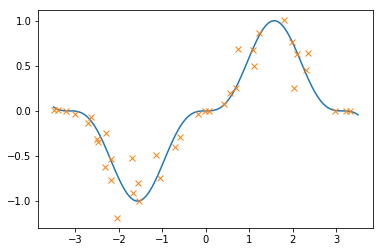

In [0]:
size = (5,)

X = 7 * torch.rand(size = (40,) ) - 3.5
Warped_Y = torch.sin(X) +0.1*torch.randn(X.shape, ) 

#note that we use f(x) = x^{1/3} as the warping function
Y = Warped_Y ** 3
Warped_Y_max = torch.max(Warped_Y).numpy() 
Warped_Y_min = torch.min(Warped_Y).numpy() 

X_test = torch.linspace(-3.5,3.5,30)
Y_test = torch.sin(X_test)**3

plt.plot(torch.linspace(-3.5,3.5,100).numpy(), 
        torch.sin(torch.linspace(-3.5,3.5,100)).numpy()**3)

plt.plot(X.numpy(),Y.numpy(),'x')

## 3.1 Showing the Learned Transformations

Text(0.5, 0, '$y$')

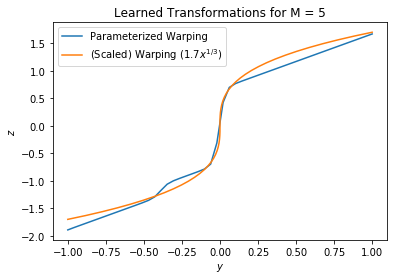

In [0]:
m = 5
# A_, B_, C_, _LS, _NP = WGP_plot_transformation(X,Y,X_test,size = (m,))
plt.plot( torch.linspace(-1,1,50).numpy(), Warp( A_, B_, C_, torch.linspace(-1,1,50) ).detach().numpy(), label = 'Parameterized Warping')
plt.plot( np.linspace(-1,1,50)**3, 1.7*np.linspace(-1,1,50),   label = r'(Scaled) Warping ($1.7x^{1/3}$)')
plt.legend()
plt.title('Learned Transformations for M = ' + str(m))
plt.ylabel(r'$z$')
plt.xlabel(r'$y$')

## 3.2 Comparison between Warped GP and GP

In [0]:
trials = 10
M = [1,2,3,5] #the complexity of the transformation approximation

GP_errors = np.zeros(trials)
WGP_errors = np.zeros((len(M),trials))

for i in range(trials):
  
  X = 7 * torch.rand(size = (40,) ) - 3.5
  Warped_Y = torch.sin(X) +0.1*torch.randn(X.shape, ) 
  Y = Warped_Y ** 3
  
  
  Y_pred = GP_train(X,Y, X_test, Y_test)
  GP_errors[i] = torch.mean((Y_pred - Y_test)**2).numpy()
  for j,m in enumerate(M):
    Y_pred = WGP_train(X,Y, X_test, Y_test, size = (m,))
    WGP_errors[j,i] = torch.mean((Y_pred - Y_test)**2).numpy()
  
  
print('Warped GP MSE =', np.mean(WGP_errors, axis = 1))
print('GP MSE =', np.mean(GP_errors))

print('Warped GP RMSE =', np.sqrt(np.mean(WGP_errors, axis = 1)))
print('GP RMSE =', np.sqrt(np.mean(GP_errors)))

print('Warped GP SD =', np.std(WGP_errors, axis = 1))
print('GP SD =', np.std(GP_errors))

Warped GP MSE = [0.0066476  0.00712369 0.00677736 0.00610486]
GP MSE = 0.008297738316468895
Warped GP RMSE = [0.0815328  0.08440198 0.08232474 0.07813362]
GP RMSE = 0.09109192234478804
Warped GP SD = [0.00241267 0.00252566 0.00210192 0.00231001]
GP SD = 0.00452623493819088


# 4. Commodities Dataset

In [0]:

DF_AL = get_predictors('al_lme_prices', predictors)
AL = price_to_returns(DF_AL, 5).iloc[:,[0]]

DF_CU = get_predictors('cu_lme_prices', predictors)
CU = price_to_returns(DF_CU, 1).iloc[:,[0]]

# DF_all = pd.merge(DF_AL, DF_CU, how = 'inner', left_index=True, right_index=True)
# print(DF_all.columns)

# #this is the price data
# DF_all = DF_all.loc[:,['al_lme_prices', 'cu_lme_prices']]#, 'ted_x', 'gsci_x']]



In [0]:
# Comparisons of errors (Aluminium)

def compare_GP_and_WGP(window, horizon, Target_Variable, kernel, M, trials):
  num_datapoints = 50
  
  WGP_error = np.zeros((len(M), trials))
  GP_error = np.zeros(trials)
  
  WGP_sign = np.zeros((len(M), trials))
  GP_sign = np.zeros(trials)
  
  BM_error = np.zeros(trials)
  
  # DF generation and feature extraction
  DF = feature_generation(Target_Variable[0:2], time_pred = [1,5,22])
  DF = feature_extraction(DF, Target_Variable, horizon)
    
  
  # now get X and Y
  Y = DF.loc[:,[Target_Variable]]
#   X = DF.drop(Target_Variable, axis = 1)
  X = Y.shift(horizon).iloc[horizon:,:]
  Y = Y.iloc[horizon:,:]
  
  for j in range(trials):

    #start at a random point
    START = int(np.random.choice(np.arange(len(Y) - 200),1) )
    END = START + window
    
    X_train = torch.tensor( X.iloc[START:END, :].values , dtype = torch.float32)
    X_test = torch.tensor( X.iloc[[(END+horizon-1)], :].values , dtype = torch.float32)
    Y_train = torch.tensor( Y.iloc[START:END, :].values.T.squeeze() , dtype = torch.float32)
    Y_test = torch.tensor( Y.iloc[[(END+horizon-1)], :].values.T.squeeze() , dtype = torch.float32)

    ##############################
    for r,m in enumerate(M):
      
      Y_pred,LLH = WGP_train(X_train,Y_train,X_test,Y_test, size = (m,), ARD = True)
      WGP_error[r,j] = ((Y_pred.detach() - Y_test)**2).numpy()
      WGP_sign[r,j] = (torch.sign(Y_pred.detach()) == torch.sign(Y_test)).numpy()
      
    ################################################################

    Y_pred = GP_train(X_train,Y_train,X_test,Y_test, kernel)

    GP_error[j] = ((Y_pred.detach() - Y_test)**2).numpy()
    GP_sign[j] = (torch.sign(Y_pred.detach()) == torch.sign(Y_test)).numpy()
    
    BM_error[j] =  Y_test.numpy()**2
    
  return GP_error, WGP_error, GP_sign, WGP_sign, BM_error


In [0]:


def Experiment_returns(T_list, Target_Variables, kernel, M, trials):
  for TV,t in zip(Target_Variables,T_list):
    GP_error, WGP_error, GP_sign, WGP_sign, BM_error =  compare_GP_and_WGP(window = 100, 
                                                                           horizon = t, 
                                                                           Target_Variable = TV, 
                                                                           kernel = kernel, 
                                                                           M = M, 
                                                                           trials = trials)
    print('For T+',t)
    for i,m in enumerate(M):
      print('M = ', m)
      print('WGP_MSE = ', np.mean(WGP_error[i,:]))
      print('WGP_MSE_STD = ', np.std(WGP_error[i,:]))
      print('WGP_RMSE = ', np.mean(WGP_error[i,:])**0.5 )
      print('WGP_SIGN =', np.mean(WGP_sign[i,:]))
      print(' ')
    
    print('GP_MSE = ', np.mean(GP_error))
    print('GP_MSE_STD = ', np.std(GP_error))
    print('GP_RMSE = ', np.mean(GP_error)**0.5 )
    print('GP_SIGN =', np.mean(GP_sign))
    print(' ' )
    print('BM_MSE = ', np.mean(BM_error))

# With All features

In [0]:
Experiment_returns(T_list = [1,5,22], Target_Variables= ['al_lme_prices_LD_1', 'al_lme_prices_LD_5', 'al_lme_prices_LD_22'], kernel = gpytorch.kernels.RBFKernel, M = [2,3,5], trials = 200)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 1
M =  2
WGP_MSE =  0.00018024213243843
WGP_MSE_STD =  0.00037261703450334896
WGP_RMSE =  0.013425428575596013
WGP_SIGN = 0.52
 
M =  3
WGP_MSE =  0.00018892952896413628
WGP_MSE_STD =  0.0003860068466911566
WGP_RMSE =  0.013745163839115788
WGP_SIGN = 0.53
 
M =  5
WGP_MSE =  0.00018847063635724518
WGP_MSE_STD =  0.0003825354334852831
WGP_RMSE =  0.013728460815300643
WGP_SIGN = 0.48
 
GP_MSE =  0.00017935458029290528
GP_MSE_STD =  0.00038228945134502945
GP_RMSE =  0.013392332892103051
GP_SIGN = 0.48
 
BM_MSE =  0.00017389356920848086


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 5
M =  2
WGP_MSE =  0.002128470996860115
WGP_MSE_STD =  0.003698195685776343
WGP_RMSE =  0.04613535517214661
WGP_SIGN = 0.49
 
M =  3
WGP_MSE =  0.0017618496415988919
WGP_MSE_STD =  0.0025952981550973983
WGP_RMSE =  0.041974392688863195
WGP_SIGN = 0.505
 
M =  5
WGP_MSE =  0.00197223539597843
WGP_MSE_STD =  0.0035232712390823517
WGP_RMSE =  0.044409856968677906
WGP_SIGN = 0.49
 
GP_MSE =  0.0012193997029607661
GP_MSE_STD =  0.0023356404268861544
GP_RMSE =  0.03491990410869947
GP_SIGN = 0.475
 
BM_MSE =  0.0009313923654965973


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 22
M =  2
WGP_MSE =  0.011453252108759724
WGP_MSE_STD =  0.018140475535410545
WGP_RMSE =  0.10701986782256706
WGP_SIGN = 0.52
 
M =  3
WGP_MSE =  0.008346924609140185
WGP_MSE_STD =  0.013207176124740254
WGP_RMSE =  0.09136150507265182
WGP_SIGN = 0.495
 
M =  5
WGP_MSE =  0.006769672547684707
WGP_MSE_STD =  0.0100621525932312
WGP_RMSE =  0.08227801983327447
WGP_SIGN = 0.52
 
GP_MSE =  0.01196529134036659
GP_MSE_STD =  0.019635848121906056
GP_RMSE =  0.10938597414827272
GP_SIGN = 0.455
 
BM_MSE =  0.004185150120385033


In [0]:
Experiment_returns(T_list = [1,5,22], Target_Variables= ['cu_lme_prices_LD_1', 'cu_lme_prices_LD_5', 'cu_lme_prices_LD_22'], kernel = gpytorch.kernels.RBFKernel, M = [2,3,5], trials = 200)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 1
M =  2
WGP_MSE =  0.00028845433216036497
WGP_MSE_STD =  0.0005793735629180618
WGP_RMSE =  0.016983943363081642
WGP_SIGN = 0.53
 
M =  3
WGP_MSE =  0.00028516880417853494
WGP_MSE_STD =  0.00056577660834176
WGP_RMSE =  0.016886941824336782
WGP_SIGN = 0.52
 
M =  5
WGP_MSE =  0.0002875856846742411
WGP_MSE_STD =  0.000573788403102407
WGP_RMSE =  0.016958351472777095
WGP_SIGN = 0.53
 
GP_MSE =  0.0002749435992063079
GP_MSE_STD =  0.0005777025296566684
GP_RMSE =  0.016581423316660963
GP_SIGN = 0.48
 
BM_MSE =  0.0002576017871266778


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 5
M =  2
WGP_MSE =  0.003202109332298875
WGP_MSE_STD =  0.0048671530028471235
WGP_RMSE =  0.056587183463209005
WGP_SIGN = 0.475
 
M =  3
WGP_MSE =  0.0028989432871605915
WGP_MSE_STD =  0.004209777496034997
WGP_RMSE =  0.053841835845006174
WGP_SIGN = 0.465
 
M =  5
WGP_MSE =  0.0023530304740606313
WGP_MSE_STD =  0.0036027130604402192
WGP_RMSE =  0.048508045457023224
WGP_SIGN = 0.5
 
GP_MSE =  0.0019025238651842803
GP_MSE_STD =  0.0031559051967597453
GP_RMSE =  0.04361793054678638
GP_SIGN = 0.475
 
BM_MSE =  0.0011325626603090376


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 22
M =  2
WGP_MSE =  0.018428784068545614
WGP_MSE_STD =  0.03158133127734583
WGP_RMSE =  0.13575265768501776
WGP_SIGN = 0.515
 
M =  3
WGP_MSE =  0.013499556656817617
WGP_MSE_STD =  0.028566761458361584
WGP_RMSE =  0.11618759252526759
WGP_SIGN = 0.47
 
M =  5
WGP_MSE =  0.01106110498751633
WGP_MSE_STD =  0.02366078844206461
WGP_RMSE =  0.10517178798288222
WGP_SIGN = 0.515
 
GP_MSE =  0.019346840467598554
GP_MSE_STD =  0.040564520865392695
GP_RMSE =  0.13909292026411177
GP_SIGN = 0.475
 
BM_MSE =  0.007811189810890368


# With Naive features

In [0]:
Experiment_returns(T_list = [1,5,22], Target_Variables= ['al_lme_prices_LD_1', 'al_lme_prices_LD_5', 'al_lme_prices_LD_22'], kernel = gpytorch.kernels.RBFKernel, M = [2,3,5], trials = 200)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 1
M =  2
WGP_MSE =  0.00028113065631651225
WGP_MSE_STD =  0.000508190785432998
WGP_RMSE =  0.016766951312522864
WGP_SIGN = 0.495
 
M =  3
WGP_MSE =  0.00028169092559663755
WGP_MSE_STD =  0.0005090326868485751
WGP_RMSE =  0.016783650544402954
WGP_SIGN = 0.515
 
M =  5
WGP_MSE =  0.00028047924074787014
WGP_MSE_STD =  0.0005078855976632767
WGP_RMSE =  0.016747514464775664
WGP_SIGN = 0.51
 
GP_MSE =  0.00027238198728416483
GP_MSE_STD =  0.00047689505213957013
GP_RMSE =  0.016503999130034055
GP_SIGN = 0.525
 
BM_MSE =  0.0002758940482295724


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 5
M =  2
WGP_MSE =  0.0010983768538853488
WGP_MSE_STD =  0.0024475177060379705
WGP_RMSE =  0.03314176902166432
WGP_SIGN = 0.51
 
M =  3
WGP_MSE =  0.0010821578960813262
WGP_MSE_STD =  0.0023202381752195946
WGP_RMSE =  0.0328961684103381
WGP_SIGN = 0.52
 
M =  5
WGP_MSE =  0.0010843469082532286
WGP_MSE_STD =  0.002311539451218718
WGP_RMSE =  0.03292942313878621
WGP_SIGN = 0.52
 
GP_MSE =  0.0010904644816258258
GP_MSE_STD =  0.0023198320891786306
GP_RMSE =  0.033022181660602404
GP_SIGN = 0.53
 
BM_MSE =  0.0011137354572383273


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 22
M =  2
WGP_MSE =  0.005804086247797669
WGP_MSE_STD =  0.009977203049967513
WGP_RMSE =  0.07618455386623767
WGP_SIGN = 0.56
 
M =  3
WGP_MSE =  0.006092592238688627
WGP_MSE_STD =  0.010153791095267777
WGP_RMSE =  0.07805505902046726
WGP_SIGN = 0.54
 
M =  5
WGP_MSE =  0.006141865284669166
WGP_MSE_STD =  0.010321674666541656
WGP_RMSE =  0.07837005349410682
WGP_SIGN = 0.54
 
GP_MSE =  0.005629003812255178
GP_MSE_STD =  0.009586597033106114
GP_RMSE =  0.07502668733360934
GP_SIGN = 0.53
 
BM_MSE =  0.003921141136771453


In [0]:
Experiment_returns(T_list = [1,5,22], Target_Variables= ['cu_lme_prices_LD_1', 'cu_lme_prices_LD_5', 'cu_lme_prices_LD_22'], kernel = gpytorch.kernels.RBFKernel, M = [2,3,5], trials = 200)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 1
M =  2
WGP_MSE =  0.00029007501353119623
WGP_MSE_STD =  0.0011735636514734863
WGP_RMSE =  0.01703158869663063
WGP_SIGN = 0.475
 
M =  3
WGP_MSE =  0.000286359349077534
WGP_MSE_STD =  0.001141179942332123
WGP_RMSE =  0.016922155568293715
WGP_SIGN = 0.48
 
M =  5
WGP_MSE =  0.00029017660103908076
WGP_MSE_STD =  0.0011463999300991554
WGP_RMSE =  0.01703457076180908
WGP_SIGN = 0.465
 
GP_MSE =  0.0002958767804581735
GP_MSE_STD =  0.0011393236949509688
GP_RMSE =  0.017201069166135386
GP_SIGN = 0.465
 
BM_MSE =  0.00029824694892342573


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 5
M =  2
WGP_MSE =  0.0013174070017293689
WGP_MSE_STD =  0.0020161317469900145
WGP_RMSE =  0.03629610174287824
WGP_SIGN = 0.5
 
M =  3
WGP_MSE =  0.0013234560958914948
WGP_MSE_STD =  0.0020391545955311258
WGP_RMSE =  0.03637933611119772
WGP_SIGN = 0.49
 
M =  5
WGP_MSE =  0.001305169879963799
WGP_MSE_STD =  0.0020022314522065267
WGP_RMSE =  0.0361271349537131
WGP_SIGN = 0.48
 
GP_MSE =  0.0013093281594009376
GP_MSE_STD =  0.0020304476240202715
GP_RMSE =  0.036184639826878716
GP_SIGN = 0.475
 
BM_MSE =  0.001150226449918108


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 22
M =  2
WGP_MSE =  0.006878417507392242
WGP_MSE_STD =  0.013726201984156177
WGP_RMSE =  0.08293622554343935
WGP_SIGN = 0.54
 
M =  3
WGP_MSE =  0.007004955303545153
WGP_MSE_STD =  0.013331681997574054
WGP_RMSE =  0.08369561101721615
WGP_SIGN = 0.53
 
M =  5
WGP_MSE =  0.006865469240180923
WGP_MSE_STD =  0.012586038791823996
WGP_RMSE =  0.08285812718243711
WGP_SIGN = 0.53
 
GP_MSE =  0.006264326895674514
GP_MSE_STD =  0.013346628908901113
GP_RMSE =  0.07914750088078912
GP_SIGN = 0.55
 
BM_MSE =  0.00486780404187817


# Significance Testing

In [0]:
Experiment_returns(T_list = [22], Target_Variables= ['al_lme_prices_LD_22'], 
                   kernel = gpytorch.kernels.RBFKernel, M = [2,3,5], trials = 1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


For T+ 22
M =  2
WGP_MSE =  0.00587182349443386
WGP_MSE_STD =  0.010361090449851005
WGP_RMSE =  0.07662782454457297
WGP_SIGN = 0.564
 
M =  3
WGP_MSE =  0.006092120109506823
WGP_MSE_STD =  0.010904489499359966
WGP_RMSE =  0.07805203462759201
WGP_SIGN = 0.567
 
M =  5
WGP_MSE =  0.005742730631973608
WGP_MSE_STD =  0.009864315050089929
WGP_RMSE =  0.07578080648801257
WGP_SIGN = 0.567
 
GP_MSE =  0.005439792639385043
GP_MSE_STD =  0.00969347746428196
GP_RMSE =  0.07375494993141167
GP_SIGN = 0.59
 
BM_MSE =  0.004581105389448539
